In [1]:
# !sudo apt install gcc -y

# !pip install catboost
# !pip install pandas
# !pip install -U scikit-learn
# !pip install seaborn
# !pip install pyarrow
# !pip install transformers
# !pip install setfit
# !pip install torch
# !pip install xformers
# !pip install py-stringmatching

In [2]:
!nvidia-smi

Tue May 30 18:01:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
|  0%   54C    P8    14W / 170W |      1MiB / 12288MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import json
from functools import partial
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
from scipy.spatial.distance import cosine, euclidean
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split

from transformers import pipeline

from sklearn.model_selection import KFold

In [4]:
features = pd.read_parquet("denis_features2.parquet")
features

,target,variantid1,variantid2,name1,categories1,color_parsed1,pic_embeddings_resnet_v11,main_pic_embeddings_resnet_v11,name_bert_641,characteristic_attributes_mapping1,...,cat3_grouped,text,deberta_label_0,deberta_score_0,deberta_label_1,deberta_score_1,deberta_label_2,deberta_score_2,deberta_label_4,deberta_score_4
0,0.0,51197862,51198054,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...","{""Число жил"":[""3""],""Макс. нагрузка, Вт"":[""3500...",...,"Сетевые фильтры, разветвители и удлинители",Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,0,0.97,0,0.97,0,0.97,0,0.97
1,0.0,51197862,51199884,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...","{""Число жил"":[""3""],""Макс. нагрузка, Вт"":[""3500...",...,"Сетевые фильтры, разветвители и удлинители",Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,0,0.97,0,0.97,0,0.97,0,0.97
2,1.0,53062686,536165289,Картридж лазерный Комус 729 (4370B002) черный ...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Расходн...","[черный, чер]",None,"[[-0.0032773763, 0.32531193, -0.33156675, 0.41...","[-0.53706163, 0.37264067, 0.44363657, -0.37289...","{""Количество в упаковке, шт"":[""1""],""Бренд"":[""К...",...,Расходник для печати,Картридж лазерный Комус 729 (4370B002) черный ...,0,0.79,0,0.86,0,0.83,0,0.74
3,1.0,53602615,587809782,Картридж лазерный Комус 729 (4368B002) пурпурн...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Расходн...",[пурпурный],None,"[[0.027616128, 0.33428708, -0.37326592, 0.4108...","[-0.61162275, 0.4953002, 0.47400212, -0.429568...","{""Назначение"":[""для лазерного принтера""],""Совм...",...,Расходник для печати,Картридж лазерный Комус 729 (4368B002) пурпурн...,0,0.81,0,0.84,0,0.82,0,0.80
4,1.0,53602615,615149925,Картридж лазерный Комус 729 (4368B002) пурпурн...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Расходн...",[пурпурный],None,"[[0.027616128, 0.33428708, -0.37326592, 0.4108...","[-0.61162275, 0.4953002, 0.47400212, -0.429568...","{""Назначение"":[""для лазерного принтера""],""Совм...",...,Расходник для печати,Картридж лазерный Комус 729 (4368B002) пурпурн...,1,0.94,1,0.94,1,0.95,1,0.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306535,0.0,810680230,820119986,"Комплект 4 шт, Картридж лазерный NV Print 4072...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Расходн...",[черный],None,"[[-0.0944288, 0.8932959, 0.25614977, -0.191978...","[-0.6026151, 0.3903093, 0.74605453, -0.6013487...","{""Емкость"":[""Стандартная""],""Совместимые модели...",...,Расходник для печати,"Комплект 4 шт, Картридж лазерный NV Print 4072...",0,0.97,0,0.97,0,0.96,0,0.97
306536,0.0,812434186,815345877,Для iPhone 7 плюс 8 плюс военная броня гибридн...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Чехол"",...",[желтый],"[[0.28905904, -2.2125282, -0.51811993, 0.59951...","[[0.17367405, -1.9180702, -0.3562176, 1.175615...","[-0.73866224, 0.50003415, 0.38444322, -0.50629...","{""Вид чехла"":[""Обложка""],""Рекомендовано для"":[...",...,Чехол,Для iPhone 7 плюс 8 плюс военная броня гибридн...,1,0.50,0,0.87,0,0.52,1,0.65
306537,0.0,815637954,817550808,Карта памяти 64 ГБ,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Карты п...",None,"[[0.025763443, 0.29543704, -0.41198447, 0.1375...","[[0.19128616, 0.530021, 0.57061875, 0.59129846...","[-0.41885406, 0.4686782, 0.48758537, -0.452275...","{""Материал корпуса"":[""ABS пластик""],""Тип карты...",...,Карты памяти и флешки,Карта памяти 64 ГБ[SEP]Карта памяти 1 ТБ,0,0.97,0,0.97,0,0.98,0,0.98
306538,0.0,817327230,822083612,"Смартфон Mate48 Pro.. 8/256 ГБ, зеленый","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Смартфо...",[зелены

In [5]:
features.shape

(306540, 33)

In [7]:
from collections import Counter
# Сделал на трейне, хотя так лучше делать, но мало времени уже
features["json1"] = features["characteristic_attributes_mapping1"].apply(
    lambda x: json.loads(x) if x is not None else None)
features["json2"] = features["characteristic_attributes_mapping2"].apply(
    lambda x: json.loads(x) if x is not None else None)

In [8]:
from pandas import json_normalize

In [9]:
key_counter = Counter()
for col in ("json1", "json2"):
    for d in features[col].values:
        if type(d) is not dict:
            continue
        for k in d.keys():
            key_counter[k] += 1
            
popular_characteristics = {k[0] for k in key_counter.most_common(100)}

In [10]:
key_counter = {k: v for k, v in key_counter.items() if k in popular_characteristics}

In [11]:
for col in key_counter:
    features[col + "_1"] = ""
    features[col + "_2"] = ""

/tmp/ipykernel_4619/2521095906.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[col + "_2"] = ""
/tmp/ipykernel_4619/2521095906.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[col + "_1"] = ""
/tmp/ipykernel_4619/2521095906.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  

In [12]:
key_dict_1 = {k: list() for k in key_counter}
for d in features["json1"].values:
    for k in key_dict_1:
        if type(d) != dict:
            key_dict_1[k].append("")
        elif k in d:
            key_dict_1[k].append(d[k])
        else:
            key_dict_1[k].append("")
for k, v in key_dict_1.items():
    features[k + "_1"] = ["; ".join(l) for l in v]

key_dict_2 = {k: list() for k in key_counter}
for d in features["json2"].values:
    for k in key_dict_2:
        if type(d) != dict:
            key_dict_2[k].append("")
        elif k in d:
            key_dict_2[k].append(d[k])
        else:
            key_dict_2[k].append("")
for k, v in key_dict_2.items():
    features[k + "_2"] = ["; ".join(l) for l in v]

In [14]:
features[features["Тип_1"] != features["Тип_2"]]

,target,variantid1,variantid2,name1,categories1,color_parsed1,pic_embeddings_resnet_v11,main_pic_embeddings_resnet_v11,name_bert_641,characteristic_attributes_mapping1,...,Тип корпуса_1,Тип корпуса_2,Количество основных камер_1,Количество основных камер_2,Встроенная память_1,Встроенная память_2,"Макс. время работы (музыка), ч_1","Макс. время работы (музыка), ч_2",Кол-во выходов HDMI_1,Кол-во выходов HDMI_2
59,1.0,89303746,290772995,"Компактный фотоаппарат Canon IXUS 185, серебри...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Фотоапп...",[серебристый],"[[-0.14365906, 0.3039319, -0.17923659, 0.46160...","[[0.024361014, 0.2643203, -0.21764697, 0.51659...","[-0.49188238, 0.52965426, 0.6110058, -0.466347...","{""Замер экспозиции"":[""Матричный"",""Точечный"",""Ц...",...,,,,,,256 ГБ,,,,
60,0.0,89403250,90341703,Беспроводное зарядное устройство - Хаб WiWU Ap...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Зарядны...","[silver, серебристый]",None,"[[-0.5024452, -0.10618199, -0.36562154, -0.210...","[-0.68346447, 0.5642679, 0.5823167, -0.5985491...","{""Страна-изготовитель"":[""Китай""],""Тип"":[""Беспр...",...,,,,,,,,,,
61,1.0,89402194,90341703,Беспроводное зарядное устройство - Хаб WiWU Ap...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Зарядны...","[silver, серебристый]",None,"[[-0.5024452, -0.10618199, -0.36562154, -0.210...","[-0.68346447, 0.5642679, 0.5823167, -0.5985491...","{""Цвет товара"":[""серебристый""],""Бренд"":[""WIWU""...",...,,,,,,,,,,
102,1.0,89713953,724265972,1 ТБ Внешний жесткий диск Netac K331 (NT05K331...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Жесткие...",[черный],"[[-0.20244174, -0.55485827, -0.10468367, 0.262...","[[0.23155072, -0.6664294, -0.2483123, -0.01467...","[-0.6338892, 0.7859347, 0.49124542, -0.3956729...","{""Интерфейс диска"":[""USB 3.0""],""Материал корпу...",...,,,,,,,,,,
115,0.0,90548895,529247977,Профессиональный кабель HDMI 2.0 GCR 30 метров...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Кабели ...","[черный, gold]","[[0.6726136, -0.34890902, 1.5980982, -0.108175...","[[0.73695177, 0.401531, 1.4233143, 0.9096911, ...","[-0.49789274, 0.55140173, 0.310619, -0.4590079...","{""Длина, м"":[""30""],""Коннектор 1"":[""HDMI""],""Стр...",...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306455,1.0,690376246,763265313,"Игровые наушники Genius HS-04S Single, черный,...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Наушник...","[черный, серебристый]","[[0.29612386, -0.66728127, 0.0342375, 0.901547...","[[-0.17295873, -1.3633852, 0.3056314, 1.006856...","[-0.71263385, 0.44036585, 0.5475284, -0.476382...","{""Цвет товара"":[""серебристый"",""черный""],""Акуст...",...,,,,,,,,,,
306468,1.0,707995123,785882558,Телескоп Levenhuk LabZZ TK50,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Оптичес...",None,"[[0.39731163, 0.05967184, 0.16574073, -0.05965...","[[0.113965474, -0.30424783, -0.023253754, 0.09...","[-0.4563114, 0.5472999, 0.7245188, -0.5444278,...","{""Оптическая схема"":[""Ахроматическая""],""Функци...",...,,,,,,,,,,
306494,1.0,738630360,763827599,Тонер-картридж совместимый Кактус Cactus CS-PH...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Расходн...","[желтый, yellow]",None,"[[-0.12317475, 1.2100722, 0.490329, 0.5828161,...","[-0.7360316, 0.62522787, 0.5524034, -0.6947981...","{""Ресурс"":[""1000""],""Комплектация"":[""Тонер-карт...",...,,,,,,,,,,
306496,1.0,740522069,757597320,Компьютерная гарнитура HyperX Cloud Stinger,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Наушник...",[черный],"[[0.21961635, 0.12991634, 0.81056464, 0.169057...","[[0.026360936, -0.064888835, -0.06389009, 1.61...","[-0.42947268, 0.6988508, 0.24307695, -0.585185...","{""Страна-изготовитель"":[""Китай""],""Подсветка"":[...",...,,,,,,,,,,


In [15]:
import py_stringmatching as sm

In [16]:
from py_stringmatching import QgramTokenizer

In [17]:
def Levenshtein_distance(x, y):
    return sm.Levenshtein().get_sim_score(x, y)

features['Levenshtein_distance'] = features.apply(lambda row: Levenshtein_distance(row['name1'], row['name2']), axis=1)

/tmp/ipykernel_4619/4257099625.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features['Levenshtein_distance'] = features.apply(lambda row: Levenshtein_distance(row['name1'], row['name2']), axis=1)


In [18]:
qg2_tok = QgramTokenizer(qval=2, return_set=True)

def Jaccard_distance(x, y):
    x_tokens = qg2_tok.tokenize(x)
    y_tokens = qg2_tok.tokenize(y)
    return sm.Jaccard().get_sim_score(x_tokens, y_tokens)

features['Jaccard_distance'] = features.apply(lambda row: Jaccard_distance(row['name1'], row['name2']), axis=1)

/tmp/ipykernel_4619/2421372635.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features['Jaccard_distance'] = features.apply(lambda row: Jaccard_distance(row['name1'], row['name2']), axis=1)


In [19]:
features['Levenshtein_distance_types'] = features.apply(
    lambda row: Levenshtein_distance(str(row['Тип_1']), str(row['Тип_2'])), axis=1)
features['Levenshtein_distance_brands'] = features.apply(
    lambda row: Levenshtein_distance(str(row['Бренд_1']), str(row['Бренд_2'])), axis=1)

/tmp/ipykernel_4619/1727125191.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features['Levenshtein_distance_types'] = features.apply(
/tmp/ipykernel_4619/1727125191.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features['Levenshtein_distance_brands'] = features.apply(


In [20]:
features['Jaccard_distance_types'] = features.apply(
    lambda row: Jaccard_distance(row['Тип_1'], row['Тип_2']), axis=1)
features['Jaccard_distance_brands'] = features.apply(
    lambda row: Jaccard_distance(row['Бренд_1'], row['Бренд_2']), axis=1)

/tmp/ipykernel_4619/2390358132.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features['Jaccard_distance_types'] = features.apply(
/tmp/ipykernel_4619/2390358132.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features['Jaccard_distance_brands'] = features.apply(


### Metric

In [21]:
import numpy as np
from sklearn.metrics import precision_recall_curve, auc


def pr_auc_macro(
    target_df: pd.DataFrame,
    predictions_df: pd.DataFrame,
    prec_level: float = 0.75,
    cat_column: str = "cat3_grouped"
) -> float:

    df = target_df.merge(predictions_df, on=["variantid1", "variantid2"])

    y_true = df["target"]
    y_pred = df["scores"]
    categories = df[cat_column]

    weights = []
    pr_aucs = []

    unique_cats, counts = np.unique(categories, return_counts=True)

    # calculate metric for each big category
    for i, category in enumerate(unique_cats):
        # take just a certain category
        cat_idx = np.where(categories == category)[0]
        y_pred_cat = y_pred[cat_idx]
        y_true_cat = y_true[cat_idx]

        # if there is no matches in the category then PRAUC=0
        if sum(y_true_cat) == 0:
            pr_aucs.append(0)
            weights.append(counts[i] / len(categories))
            continue
        
        # get coordinates (x, y) for (recall, precision) of PR-curve
        y, x, _ = precision_recall_curve(y_true_cat, y_pred_cat)
        
        # reverse the lists so that x's are in ascending order (left to right)
        y = y[::-1]
        x = x[::-1]
        
        # get indices for x-coordinate (recall) where y-coordinate (precision) 
        # is higher than precision level (75% for our task)
        good_idx = np.where(y >= prec_level)[0]
        
        # if there are more than one such x's (at least one is always there, 
        # it's x=0 (recall=0)) we get a grid from x=0, to the rightest x 
        # with acceptable precision
        if len(good_idx) > 1:
            gt_prec_level_idx = np.arange(0, good_idx[-1] + 1)
        # if there is only one such x, then we have zeros in the top scores 
        # and the curve simply goes down sharply at x=0 and does not rise 
        # above the required precision: PRAUC=0
        else:
            pr_aucs.append(0)
            weights.append(counts[i] / len(categories))
            continue
        
        # calculate category weight anyway
        weights.append(counts[i] / len(categories))
        # calculate PRAUC for all points where the rightest x 
        # still has required precision 
        try:
            pr_auc_prec_level = auc(x[gt_prec_level_idx], y[gt_prec_level_idx])
            if not np.isnan(pr_auc_prec_level):
                pr_aucs.append(pr_auc_prec_level)
        except ValueError:
            pr_aucs.append(0)
            
    return np.average(pr_aucs, weights=weights)

Choose features

In [22]:
feats = ["pic_dist_0_perc", "pic_dist_25_perc", "pic_dist_50_perc", 
         "euclidean_name_bert_dist", "cosine_name_bert_dist",
        ]
text_features = ["name1", "name2"]

In [23]:
feats += ["Levenshtein_distance", 
         "Jaccard_distance", 'Levenshtein_distance_types',
          'Levenshtein_distance_brands', 'Jaccard_distance_types', 'Jaccard_distance_brands']

In [24]:
feats += ['deberta_label_0', 'deberta_score_0', 'deberta_label_1',
       'deberta_score_1', 'deberta_label_2', 'deberta_score_2',
       'deberta_label_4', 'deberta_score_4']

In [25]:
key_features = [k + "_1" for k in key_counter.keys()]
key_features += [k + "_2" for k in key_counter.keys()]

In [26]:
text_features = ["name1", "name2"]

In [27]:
feats += key_features

In [28]:
feats += text_features

In [29]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [30]:
splits = list(kfold.split(features))

Split dataset

In [31]:
features["diff_variant_id"] = features["variantid2"] - features["variantid1"]

/tmp/ipykernel_4619/2783017781.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features["diff_variant_id"] = features["variantid2"] - features["variantid1"]


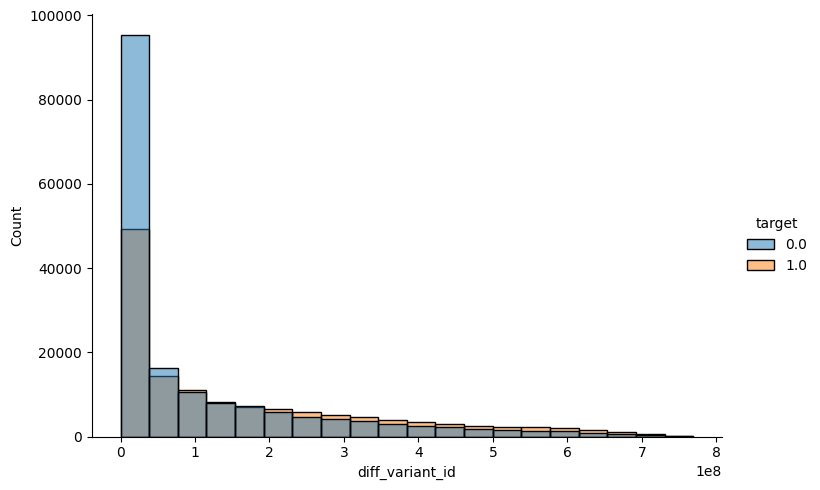

In [32]:
import seaborn as sns
sns.displot(data=features, x="diff_variant_id", hue="target", bins=20, height=5, aspect=6/4)

In [33]:
feats += ["diff_variant_id"]

In [34]:
features.to_parquet("denis_features_3.parquet")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6841977	test: 0.6844728	best: 0.6844728 (0)	total: 201ms	remaining: 5h 35m 16s
100:	learn: 0.3761350	test: 0.3912276	best: 0.3912276 (100)	total: 24.2s	remaining: 6h 38m 12s
200:	learn: 0.3441446	test: 0.3637946	best: 0.3637946 (200)	total: 46.6s	remaining: 6h 25m 29s
300:	learn: 0.3377210	test: 0.3588524	best: 0.3588524 (300)	total: 1m 5s	remaining: 6h 2m 32s
400:	learn: 0.3354937	test: 0.3572234	best: 0.3572234 (400)	total: 1m 25s	remaining: 5h 52m
500:	learn: 0.3342304	test: 0.3563641	best: 0.3563641 (500)	total: 1m 42s	remaining: 5h 39m 16s
600:	learn: 0.3333675	test: 0.3557932	best: 0.3557932 (600)	total: 1m 59s	remaining: 5h 30m 6s
700:	learn: 0.3326711	test: 0.3553453	best: 0.3553453 (700)	total: 2m 16s	remaining: 5h 22m 5s
800:	learn: 0.3320335	test: 0.3549482	best: 0.3549482 (800)	total: 2m 32s	remaining: 5h 15m 19s
900:	learn: 0.3314905	test: 0.3546542	best: 0.3546542 (900)	total: 2m 48s	remaining: 5h 8m 23s
1000:	learn: 0.3310347	test: 0.3543837	best: 0.3543837 (

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6842206	test: 0.6842906	best: 0.6842906 (0)	total: 199ms	remaining: 5h 30m 55s
100:	learn: 0.3758121	test: 0.3802263	best: 0.3802263 (100)	total: 24.7s	remaining: 6h 47m 8s
200:	learn: 0.3436805	test: 0.3498257	best: 0.3498257 (200)	total: 48.7s	remaining: 6h 42m 44s
300:	learn: 0.3375779	test: 0.3440416	best: 0.3440416 (300)	total: 1m 7s	remaining: 6h 12m 49s
400:	learn: 0.3355445	test: 0.3420942	best: 0.3420942 (400)	total: 1m 25s	remaining: 5h 51m 53s
500:	learn: 0.3344223	test: 0.3411125	best: 0.3411125 (500)	total: 1m 40s	remaining: 5h 33m 22s
600:	learn: 0.3336072	test: 0.3404808	best: 0.3404808 (600)	total: 1m 56s	remaining: 5h 21m
700:	learn: 0.3329389	test: 0.3399681	best: 0.3399681 (700)	total: 2m 11s	remaining: 5h 10m 53s
800:	learn: 0.3323441	test: 0.3395788	best: 0.3395788 (800)	total: 2m 29s	remaining: 5h 8m 36s
900:	learn: 0.3318245	test: 0.3392327	best: 0.3392327 (900)	total: 2m 46s	remaining: 5h 4m 31s
1000:	learn: 0.3313889	test: 0.3389892	best: 0.3389892 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6840805	test: 0.6842274	best: 0.6842274 (0)	total: 199ms	remaining: 5h 31m 56s
100:	learn: 0.3720193	test: 0.3808655	best: 0.3808655 (100)	total: 26.1s	remaining: 7h 10m 14s
200:	learn: 0.3400173	test: 0.3516596	best: 0.3516596 (200)	total: 49.8s	remaining: 6h 52m 2s
300:	learn: 0.3339800	test: 0.3465255	best: 0.3465255 (300)	total: 1m 7s	remaining: 6h 13m 49s
400:	learn: 0.3317899	test: 0.3446627	best: 0.3446627 (400)	total: 1m 25s	remaining: 5h 55m 56s
500:	learn: 0.3305469	test: 0.3436948	best: 0.3436948 (500)	total: 1m 42s	remaining: 5h 39m 47s
600:	learn: 0.3297089	test: 0.3430963	best: 0.3430963 (600)	total: 1m 58s	remaining: 5h 25m 43s
700:	learn: 0.3289863	test: 0.3426011	best: 0.3426011 (700)	total: 2m 14s	remaining: 5h 17m 30s
800:	learn: 0.3283498	test: 0.3421665	best: 0.3421665 (800)	total: 2m 29s	remaining: 5h 8m 59s
900:	learn: 0.3278691	test: 0.3418887	best: 0.3418887 (900)	total: 2m 44s	remaining: 5h 1m 7s
1000:	learn: 0.3274370	test: 0.3416433	best: 0.34164

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6882801	test: 0.6882428	best: 0.6882428 (0)	total: 28.2ms	remaining: 46m 55s
100:	learn: 0.4937722	test: 0.4939332	best: 0.4939332 (100)	total: 6.54s	remaining: 1h 47m 54s
200:	learn: 0.4602671	test: 0.4615886	best: 0.4615886 (200)	total: 20.2s	remaining: 2h 47m 19s
300:	learn: 0.4480809	test: 0.4499153	best: 0.4499153 (300)	total: 43.5s	remaining: 4h 11s
400:	learn: 0.4409503	test: 0.4432365	best: 0.4432365 (400)	total: 1m 4s	remaining: 4h 26m 8s
500:	learn: 0.4357551	test: 0.4384274	best: 0.4384274 (500)	total: 1m 21s	remaining: 4h 31m 5s


KeyboardInterrupt: 

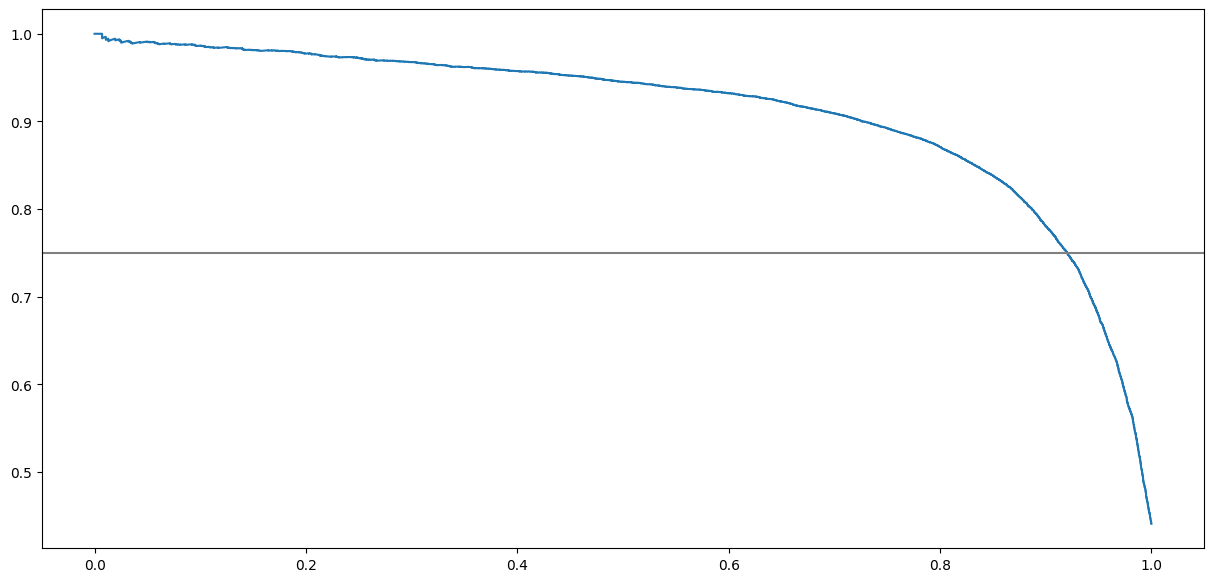

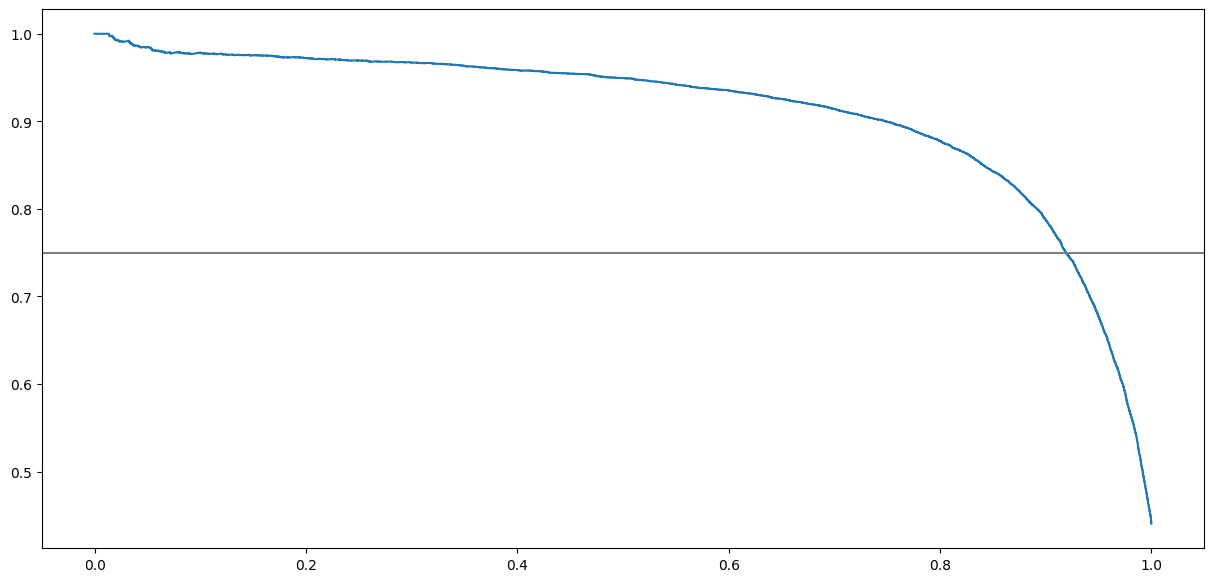

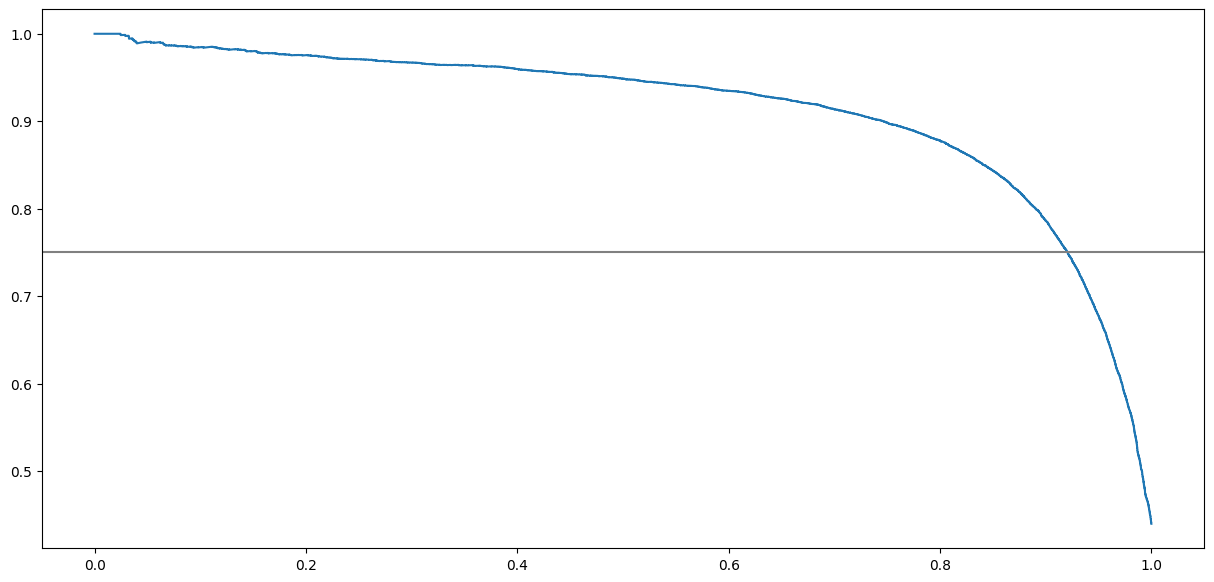

In [35]:
catboost_params = {
    'iterations': 100000,
    'learning_rate': 0.01,
    "loss_function": 'CrossEntropy',
    'verbose': 100,
    "task_type": "GPU",
    "devices": '0',
    'early_stopping_rounds': 50,
    'random_seed': 42, 
    'depth': 6
}

pr_aucs = []

models = []

for split_i, split in enumerate(splits):
    split_features = features.copy()
    split_feats = feats.copy()
    split_feats = [s for s in split_feats if "deberta_" not in s or ("deberta_" in s and str(split_i) in s)]
    split_features = split_features[split_feats + ["target", "variantid1", "variantid2", "cat3_grouped"]]
    X_train = split_features.iloc[split[0]]
    X_test = split_features.iloc[split[1]]
    X_train, X_val = train_test_split(
        X_train, 
        test_size=0.1, random_state=42,
    #     stratify=X_train[["target", "cat3_grouped"]]
    )

#     X_train.to_parquet(f"/root/fold_{split_i}_train.parquet")
#     X_test.to_parquet(f"/root/fold_{split_i}_test.parquet")
#     X_val.to_parquet(f"/root/fold_{split_i}_val.parquet")

    y_test = X_test[["target", "variantid1", "variantid2"]]
    X_test = X_test.drop(["target"], axis=1)

    y_train = X_train["target"]
    y_val = X_val["target"]

    X_train = X_train.drop(["target"], axis=1)
    X_val = X_val.drop(["target"], axis=1)

    #split_feats = [f for f in split_feats if f not in  ("target")]
    train_pool = Pool(
        data=X_train[split_feats],
        label=y_train,
        text_features = text_features,
        cat_features=key_features
    )
    eval_pool = Pool(
        data=X_val[split_feats],
        label=y_val,
        text_features = text_features,
        cat_features=key_features
    )
    model = CatBoostClassifier(**catboost_params)

    model.fit(
        train_pool,
        eval_set=eval_pool,
        plot=True,
        verbose=True,
        use_best_model=True,
        early_stopping_rounds=50,
        metric_period=100
    )
    model.save_model(f"baseline_denis_3{split_i}.cbm")
    models.append(model)
    
    
    X_test["scores"] = model.predict_proba(X_test[split_feats])[:, 1]
    pr_auc_macro_metr = pr_auc_macro(
        target_df=y_test, 
        predictions_df=X_test,
        prec_level=0.75,
        cat_column="cat3_grouped"
    )
    
    print(dict(zip(model.feature_names_, model.feature_importances_)))
    print(f"pr_auc_macro_metr: {split_i}", pr_auc_macro_metr)
    
    precision, recall, thrs = precision_recall_curve(y_test["target"], X_test["scores"])
    pr_auc = auc(recall, precision)
    pr_aucs.append(pr_auc)
    fig, ax1 = plt.subplots(1, figsize=(15, 7))

    ax1.plot(recall, precision)
    ax1.axhline(y=0.75, color='grey', linestyle='-');

### Submission

In [36]:
test_features = pd.read_parquet("denis_test_features.parquet")

In [38]:
test_features["json1"] = test_features["characteristic_attributes_mapping1"].apply(
    lambda x: json.loads(x) if x is not None else None)
test_features["json2"] = test_features["characteristic_attributes_mapping2"].apply(
    lambda x: json.loads(x) if x is not None else None)

In [39]:
key_dict_1 = {k: list() for k in key_counter}
for d in test_features["json1"].values:
    for k in key_dict_1:
        if type(d) != dict:
            key_dict_1[k].append("")
        elif k in d:
            key_dict_1[k].append(d[k])
        else:
            key_dict_1[k].append("")
for k, v in key_dict_1.items():
    test_features[k + "_1"] = ["; ".join(l) for l in v]

key_dict_2 = {k: list() for k in key_counter}
for d in test_features["json2"].values:
    for k in key_dict_2:
        if type(d) != dict:
            key_dict_2[k].append("")
        elif k in d:
            key_dict_2[k].append(d[k])
        else:
            key_dict_2[k].append("")
for k, v in key_dict_2.items():
    test_features[k + "_2"] = ["; ".join(l) for l in v]

/tmp/ipykernel_4619/3952761307.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_features[k + "_1"] = ["; ".join(l) for l in v]
/tmp/ipykernel_4619/3952761307.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_features[k + "_1"] = ["; ".join(l) for l in v]
/tmp/ipykernel_4619/3952761307.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get 

In [40]:
test_features['Levenshtein_distance'] = test_features.apply(
    lambda row: Levenshtein_distance(row['name1'], row['name2']), axis=1)
test_features['Jaccard_distance'] = test_features.apply(
    lambda row: Jaccard_distance(row['name1'], row['name2']), axis=1)

/tmp/ipykernel_4619/2370976900.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_features['Levenshtein_distance'] = test_features.apply(
/tmp/ipykernel_4619/2370976900.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_features['Jaccard_distance'] = test_features.apply(


In [41]:
test_features['Levenshtein_distance_types'] = test_features.apply(
    lambda row: Levenshtein_distance(str(row['Тип_1']), str(row['Тип_2'])), axis=1)
test_features['Levenshtein_distance_brands'] = test_features.apply(
    lambda row: Levenshtein_distance(str(row['Бренд_1']), str(row['Бренд_2'])), axis=1)
test_features['Jaccard_distance_types'] = test_features.apply(
    lambda row: Jaccard_distance(row['Тип_1'], row['Тип_2']), axis=1)
test_features['Jaccard_distance_brands'] = test_features.apply(
    lambda row: Jaccard_distance(row['Бренд_1'], row['Бренд_2']), axis=1)

/tmp/ipykernel_4619/4224834903.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_features['Levenshtein_distance_types'] = test_features.apply(
/tmp/ipykernel_4619/4224834903.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_features['Levenshtein_distance_brands'] = test_features.apply(
/tmp/ipykernel_4619/4224834903.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.con

In [42]:
test_features["diff_variant_id"] = test_features["variantid2"] - test_features["variantid1"]

/tmp/ipykernel_4619/1322436290.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_features["diff_variant_id"] = test_features["variantid2"] - test_features["variantid1"]


In [43]:
for split_i, split in enumerate(splits):
    submission_example = test_features.copy()
    split_feats = feats.copy()
    split_feats = [s for s in split_feats if "deberta_" not in s or ("deberta_" in s and str(split_i) in s)]
    submission_example = submission_example[split_feats + ["variantid1", "variantid2", "cat3_grouped"]]
    test_features[f"target_{split_i}"] = models[split_i].predict_proba(submission_example[split_feats])[:, 1]

/tmp/ipykernel_4619/1631003407.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_features[f"target_{split_i}"] = models[split_i].predict_proba(submission_example[split_feats])[:, 1]
/tmp/ipykernel_4619/1631003407.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_features[f"target_{split_i}"] = models[split_i].predict_proba(submission_example[split_feats])[:, 1]
/tmp/ipykernel_4619/1631003407.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

IndexError: list index out of range

In [50]:
((test_features["target_0"] +
 test_features["target_1"] +
 test_features["target_2"]
#   +
#  test_features["target_3"] +
#  test_features["target_4"]
 ) 
 / 3).sum()

7220.450639918546

In [51]:
# # submission_example["target"] = 
# ((test_features["target_0"] +
#  test_features["target_1"] +
#  test_features["target_2"] +
#  test_features["target_3"] +
#  test_features["target_4"]) / 5).sum()

In [53]:
submission_example["target"] = ((test_features["target_0"] +
 test_features["target_1"] +
 test_features["target_2"]
#                                  +
#  test_features["target_3"] +
#  test_features["target_4"]
                                ) / 3)

In [54]:
submission_example = submission_example[["variantid1", "variantid2", "target"]]

In [60]:
submission_example["target"] = submission_example["target"].round(2)

In [63]:
submission_example.drop_duplicates().merge(
    test_features[["variantid1", "variantid2"]].drop_duplicates(["variantid1", "variantid2"]),
    on=["variantid1", "variantid2"]
).to_csv("submission_example3.csv", index=False)

Upload your submission to leaderboard :)

### Recommendations 

- Work with names, in electronics names often contain a lot of useful information for matching.
- Don't forget about attributes: working with it will allow your model to better distinguish matches from non-matches.

In [ ]:
test_features["target"] = submission_example["target"]

In [ ]:
test_features[test_features["name1"] != test_features["name2"]]